In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import transformers
from transformers import LayoutLMv2Processor, LayoutLMForTokenClassification, AdamW, BertForTokenClassification,\
    BertTokenizer, LayoutLMTokenizer, AutoTokenizer
from datasets import load_dataset
import torch
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
import logging
from torch.utils.data import DataLoader
from torcheval.metrics.functional import multiclass_f1_score, multiclass_confusion_matrix
from copy import deepcopy

import os 
while 'notebooks' in os.getcwd():
    os.chdir("..")
    
from src.preprocessing.make_dataset import ImageLayoutDataset
from src.model.trainer import BertTrainer, LayoutLMTrainer
import warnings
warnings.filterwarnings("ignore")

In [3]:
!mkdir logs

mkdir: cannot create directory ‘logs’: File exists


In [4]:
model_name = "few_shot_learning"
dataset_name = "sroie"

In [5]:
logging.basicConfig(filename='logs/few_shot_learning_cord.log', encoding='utf-8', level= logging.INFO)

## Obtaining data

In [6]:
dataset = load_dataset("darentang/sroie",
                       cache_dir = "/Data/pedro.silva/")

In [7]:
dataset

DatasetDict({
    train: Dataset({
        features: ['id', 'words', 'bboxes', 'ner_tags', 'image_path'],
        num_rows: 626
    })
    test: Dataset({
        features: ['id', 'words', 'bboxes', 'ner_tags', 'image_path'],
        num_rows: 347
    })
})

In [8]:
dataset['train'].features['ner_tags'].feature.names

['O',
 'B-COMPANY',
 'I-COMPANY',
 'B-DATE',
 'I-DATE',
 'B-ADDRESS',
 'I-ADDRESS',
 'B-TOTAL',
 'I-TOTAL']

In [9]:
n_classes = len(dataset['train'].features['ner_tags'].feature.names)
n_classes

9

In [10]:
bert_tokenizer =AutoTokenizer.from_pretrained("bert-base-uncased")

In [11]:
llm_tokenizer = AutoTokenizer.from_pretrained("microsoft/layoutlm-base-uncased",)

## BERT

In [12]:
train_dataset = ImageLayoutDataset(
    dataset['train'], 
    tokenizer=bert_tokenizer
)

  0%|          | 0/626 [00:00<?, ?it/s]

100%|██████████| 626/626 [00:04<00:00, 125.81it/s]


In [13]:
validation_dataset = ImageLayoutDataset(
    dataset['test'],
    tokenizer= bert_tokenizer
)

  4%|▍         | 14/347 [00:00<00:02, 131.68it/s]

100%|██████████| 347/347 [00:02<00:00, 157.28it/s]


In [15]:
test_dataset = ImageLayoutDataset(
    dataset['test'],
    tokenizer= bert_tokenizer,
    tokenize_all_labels=True
)

100%|██████████| 347/347 [00:02<00:00, 157.55it/s]


In [16]:
device = "cuda"

In [19]:
n = len(train_dataset)
history= {}
test = {}



for i in [2,5,10, 100]:
    num_samples = i

    train_dataloader = DataLoader(
        train_dataset[0: num_samples],
        batch_size=1,
        shuffle = False
    )

    validation_dataloader = DataLoader(
        train_dataset[num_samples:],
        batch_size=1,
        shuffle = False
    )

    bert = BertForTokenClassification\
        .from_pretrained(
            'bert-base-uncased', 
            num_labels = n_classes
        )
    
    bert.to(device)

    trainer = BertTrainer(
        bert
    )

    print(f"training {trainer.model_name} with {num_samples} samples")

    trainer.compile(
        train_dataloader,
        validation_dataloader,
        n_classes= n_classes,
        device = "cuda"
    )

    test_dataloader = DataLoader(
        test_dataset,
        batch_size = 1
    )
    f1, conf_matrix = trainer.evaluate(
        test_dataloader,
        n_classes= n_classes
    )

    history[num_samples] = trainer.history

    test[num_samples]={

        'f1': f1,
        'confusion_matrix': conf_matrix
    }

    history[num_samples] = trainer.history

f1: 0.9751499891281128


In [20]:
for k,v in test.items():
    print(f'{k} samples: {v["f1"].item()}')

2 samples: 0.8919734358787537
5 samples: 0.9041011929512024
10 samples: 0.9248851537704468
100 samples: 0.953088641166687


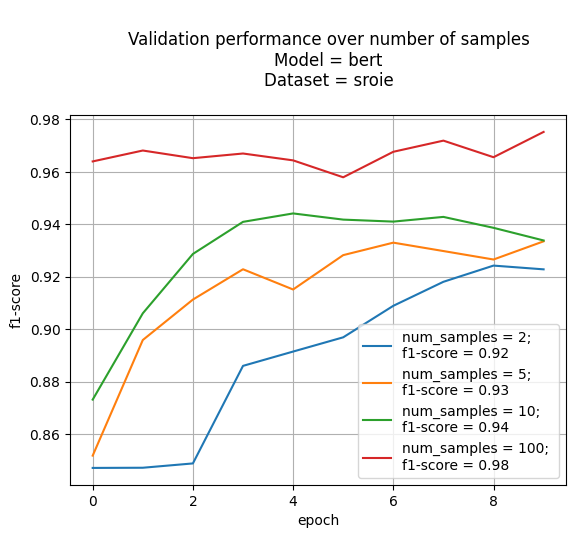

In [21]:
for k in history.keys():
    data = history[k]['validation-f1']
    plt.plot(
        data,
        label = f"num_samples = {k}; \nf1-score = {round(np.max(history[k]['validation-f1']),2)}"
    )

plt.title(f'''
    Validation performance over number of samples
    Model = {trainer.model_name}
    Dataset = {dataset_name}
''')

plt.xlabel("epoch")
plt.ylabel("f1-score")
# plt.ylim([0,1])
plt.grid()
plt.legend()
plt.show()

## LayoutLM

In [23]:
train_dataset = ImageLayoutDataset(
    dataset['train'], 
    tokenizer=llm_tokenizer
)

  0%|          | 0/626 [00:00<?, ?it/s]

100%|██████████| 626/626 [00:04<00:00, 152.80it/s]


In [24]:
validation_dataset = ImageLayoutDataset(
    dataset['test'],
    tokenizer= llm_tokenizer
)

  0%|          | 0/347 [00:00<?, ?it/s]

100%|██████████| 347/347 [00:02<00:00, 157.79it/s]


In [25]:
test_dataset = ImageLayoutDataset(
    dataset['test'],
    tokenizer= bert_tokenizer,
    tokenize_all_labels=True
)

  0%|          | 0/347 [00:00<?, ?it/s]

100%|██████████| 347/347 [00:02<00:00, 155.41it/s]


In [26]:
n = len(train_dataset)
history= {}
test = {}



for i in [2,5,10, 100]:
    num_samples = i

    train_dataloader = DataLoader(
        train_dataset[0: num_samples],
        batch_size=1,
        shuffle = False
    )

    validation_dataloader = DataLoader(
        train_dataset[num_samples:],
        batch_size=1,
        shuffle = False
    )

    layoutlm = LayoutLMForTokenClassification\
        .from_pretrained(
            'microsoft/layoutlm-base-uncased', 
            num_labels = n_classes,
            cache_dir = "/Data/pedro.silva/"
        )
    
    layoutlm.to(device)

    trainer = LayoutLMTrainer(
        layoutlm
    )

    print(f"training {trainer.model_name} with {num_samples} samples")

    trainer.compile(
        train_dataloader,
        validation_dataloader,
        n_classes= n_classes,
        device = "cuda"
    )

    test_dataloader = DataLoader(
        test_dataset,
        batch_size = 1
    )
    f1, conf_matrix = trainer.evaluate(
        test_dataloader,
        n_classes= n_classes
    )

    history[num_samples] = trainer.history

    test[num_samples]={

        'f1': f1,
        'confusion_matrix': conf_matrix
    }

    history[num_samples] = trainer.history

f1: 0.957743763923645


In [27]:
for k,v in test.items():
    print(f'{k} samples: {v["f1"].item()}')

2 samples: 0.858778178691864
5 samples: 0.8512451648712158
10 samples: 0.8735833168029785
100 samples: 0.9385671615600586


In [28]:
device = "cuda"

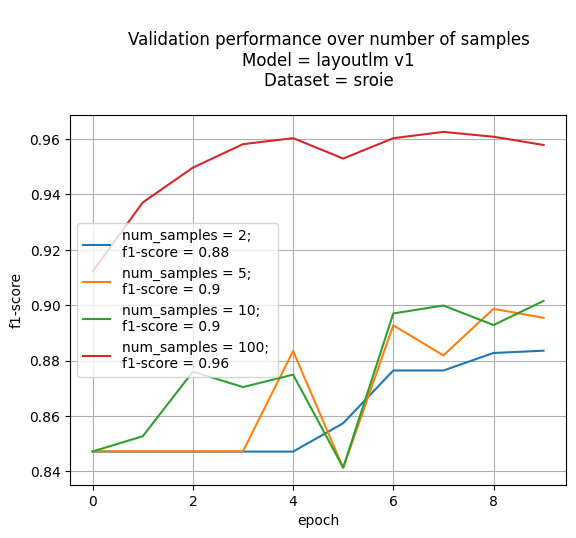

In [29]:
for k in history.keys():
    data = history[k]['validation-f1']
    plt.plot(
        data,
        label = f"num_samples = {k}; \nf1-score = {round(np.max(history[k]['validation-f1']),2)}"
    )

plt.title(f'''
    Validation performance over number of samples
    Model = {trainer.model_name}
    Dataset = {dataset_name}
''')

plt.xlabel("epoch")
plt.ylabel("f1-score")
# plt.ylim([0,1])
plt.grid()
plt.legend()
plt.show()